In [2]:
from pyclustering.cluster.bsas import bsas
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import matplotlib.lines as mlines

fig_size =[12,9]
plt.rcParams["figure.figsize"] = fig_size

In [3]:
import cv2
import numpy as np
from pyclustering.cluster.bsas import bsas
class markerExteractor(object):
    def __init__(self):
        self.max_clusters = 8
        self.threshold = 20
        self.blubParams = cv2.SimpleBlobDetector_Params()
        self.blubParams.minThreshold = 50;
        self.blubParams.maxThreshold = 255;
        self.blubParams.filterByArea = True
        self.blubParams.minArea = 0
        self.blubParams.filterByCircularity = True
        self.blubParams.minCircularity = 0.3
        self.blubParams.filterByConvexity = True
        self.blubParams.minConvexity = 0.7
        self.blubParams.filterByInertia = True
        self.blubParams.minInertiaRatio = 0.1
        self.blubParams.blobColor = 255
        ver = (cv2.__version__).split('.')
        if int(ver[0]) < 3 :
            self.blubDetector = cv2.SimpleBlobDetector(self.blubParams)
        else : 
            self.blubDetector = cv2.SimpleBlobDetector_create(self.blubParams)
    def detect(self,frame):
        self.cms=[]
        self.image_ROIs=[]
        self.keypoints=[]
        img_gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret,img_thresh = cv2.threshold(img_gray,100,255,cv2.THRESH_TOZERO)
        #Find the clusters
        self.nonzro_samples = cv2.findNonZero(img_thresh)
        if self.nonzro_samples is None:
            return None
        else:
            self.nonzro_samples=self.nonzro_samples.reshape(-1, 2).astype('float32')
        bsas_instance = bsas(self.nonzro_samples, self.max_clusters, self.threshold)
        bsas_instance.process()
        clusters = bsas_instance.get_clusters()
        #Calculate the center of the clusters and the Regions of Interests
        self.ROIs=np.zeros((len(clusters),4))
        for i,cluster in enumerate(clusters):
            current_batch=self.nonzro_samples[cluster]
            self.cms.append(np.sum(current_batch,axis=0)/current_batch.shape[0])
            row_max=np.max(current_batch[:,1],axis=0)+6
            row_min=np.min(current_batch[:,1],axis=0)-6
            col_max=np.max(current_batch[:,0],axis=0)+6
            col_min=np.min(current_batch[:,0],axis=0)-6
            self.ROIs[i,:]=[row_min,row_max,col_min,col_max]
        for roi in self.ROIs.astype('int32'):
            self.image_ROIs.append(img_thresh.copy()[roi[0]:roi[1],roi[2]:roi[3]])
        #Return The Results
        marker_points=[]
        for i,roi in enumerate(self.image_ROIs):
            keys_in_roi=self.blubDetector.detect(roi)
            for key in keys_in_roi:
                #Calculate the global coordinate of marker points. The points are returned in (X(Col),Y(Row)) coordinate. 
                marker_points.append([key.pt[0]+self.ROIs.astype('float32')[i,2],key.pt[1]+self.ROIs.astype('float32')[i,0]])
        return np.array(marker_points)

In [4]:
import yaml
class undistrodMarkers:
    def __init__(self,config_file_name):
        with open(config_file_name, 'r') as f:
            calib = yaml.safe_load(f.read())
        self.K = np.array(calib['camera_matrix']['data']).reshape(calib['camera_matrix']['rows'],calib['camera_matrix']['cols'])
        self.D = np.array(calib['distortion_coefficients']['data']).reshape(-1, 5)
        self.P = np.array(calib['projection_matrix']['data']).reshape(3, 4)
        #elf.R = np.array(calib['rectification_matrix']['data']).reshape(3, 3)
        self.img_width = calib['image_width']
        self.img_height = calib['image_height']
    def process(self,points):
        lpts_ud=cv2.undistortPoints(points.reshape(-1,1,2).astype(np.float32), self.K, self.D,P=self.P)
        return np.squeeze(cv2.convertPointsToHomogeneous(np.float32(lpts_ud))).reshape(3,1)
    def process_normalized(self,points):
        lpts_ud=cv2.undistortPoints(points.reshape(-1,1,2).astype(np.float32), self.K, self.D,P=None)
        return np.squeeze(cv2.convertPointsToHomogeneous(np.float32(lpts_ud))).reshape(3,1)

leftUndist = undistrodMarkers('left.yaml')
rightUndist = undistrodMarkers('right.yaml')

In [5]:
#Testing the algorithm with a stream of images
markerExteractor_inst=markerExteractor()
cap1=cv2.VideoCapture('output_left2.avi')
cap2=cv2.VideoCapture('output_right2.avi')

extracted_points1=[]
extracted_points2=[]

frame_counter=0;
while cap1.isOpened():
    ret,img1=cap1.read()
    ret,img2=cap2.read()
    if(img1 is not None) and (img2 is not None):
        img1=cv2.undistort(img1, leftUndist.K, leftUndist.D,None,leftUndist.P)
        img2=cv2.undistort(img2, rightUndist.K, rightUndist.D,None,rightUndist.P)
        points1=markerExteractor_inst.detect(img1)
        points2=markerExteractor_inst.detect(img2)
        if (points1 is not None) and (points2 is not None):
            if (len(points1)==1) and (len(points2)==1):#Add points to the list only if is just one point in each image
                cv2.circle(img1,(int(round(points1[0,0])), int(round(points1[0,1]))), 2, (255,0,255), -1)
                cv2.circle(img2,(int(round(points2[0,0])), int(round(points2[0,1]))), 2, (255,0,255), -1)
                extracted_points1.append(points1[0])
                extracted_points2.append(points2[0])
                img_full=np.hstack([img1,img2])
                cv2.imshow('Frame',img_full)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                if frame_counter>5000:
                    break
                frame_counter=frame_counter+1
    else:
            cv2.destroyAllWindows()     
            cap1.release()
            cap2.release()
cv2.destroyAllWindows()     
cap1.release()
cap2.release()

In [6]:
cv2.destroyAllWindows()     
cap1.release()
cap2.release()

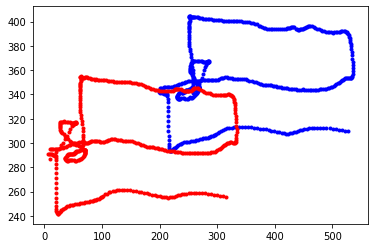

In [7]:
extracted_points1=np.vstack(extracted_points1)
extracted_points2=np.vstack(extracted_points2)
df=pd.DataFrame(np.hstack([extracted_points1,extracted_points2]),columns=['left_cam_x', 'left_cam_y', 'right_cam_x', 'right_cam_y' ])
plt.plot(extracted_points1[:,0],extracted_points1[:,1],'b.')
plt.plot(extracted_points2[:,0],extracted_points2[:,1],'r.')

plt.show()
    

In [8]:
df.to_csv('ir_tracker_dual_camera.csv')
df.head()

,left_cam_x,left_cam_y,right_cam_x,right_cam_y
0,253.592557,337.965876,9.954306,287.038068
1,258.150347,340.900879,15.877857,290.018761
2,262.259414,343.621387,21.129497,292.971529
3,265.518961,346.248426,25.733361,295.409998
4,268.264452,348.594588,29.496978,297.966630


In [9]:
F,masks =cv2.findFundamentalMat(extracted_points1,extracted_points2)

[[-0.00050791]]


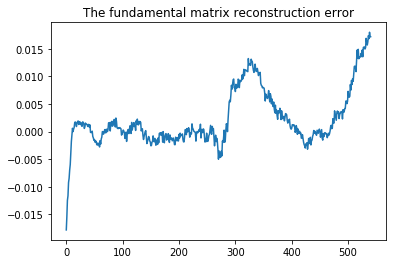

In [10]:
idx=200
P1=np.hstack([extracted_points1[idx,:] , 1.0])
P2=np.hstack([extracted_points2[idx,:] , 1.0])
P1=P1.reshape(3,1)
P2=P2.reshape(3,1)
print(np.dot(np.dot(P2.T,F),P1))
error=[]
for i in range(len(extracted_points1)):
    P1=np.hstack([extracted_points1[i,:] , 1.0])
    P2=np.hstack([extracted_points2[i,:] , 1.0])
    P1=P1.reshape(3,1)
    P2=P2.reshape(3,1)
    error.append(np.dot(np.dot(P2.T,F),P1))
error=np.array(error).reshape(-1)
plt.plot(error)
plt.title('The fundamental matrix reconstruction error')
plt.show()

In [11]:
# The equations created by x2^T*F*x1=0 
def create_row(point2,point1):
    u1=point1[0]
    v1=point1[1]
    u2=point2[0]
    v2=point2[1]
    line=np.array(\
    [u1*u2, u1*v2, u1, v1*u2, v1*v2, v1, u2, v2, 1]\
    ).reshape(1,9)
    return line
rows=[]
for i in range(200,len(extracted_points1)):
    rows.append(create_row(extracted_points2[i,:],extracted_points1[i,:]))
A=np.vstack(rows)
u,s,v=np.linalg.svd(A.T)
#F=v.T[:,8].reshape(3,3).T
#u,s,v=np.linalg.svd(F)
#s[2]=0
#F=np.matmul(u * s, v)

In [12]:
def add_epiline(img,F,point,point_index): #point index indicates which image is the one whose point is to 
                                          #be reprojected on the epiline of the corresponding image
    #point=np.squeeze(point)[0:2]
    point=np.vstack([point.reshape(2,1), 1])
    epiLines = np.dot(F,point);
    a=epiLines[0];
    b=epiLines[1];
    c=epiLines[2];
    #l=cv2.computeCorrespondEpilines(point[0:2].reshape(1,2),point_index,F).squeeze() 
#     a=l[0];
#     b=l[1];
#     c=l[2];
    x0=0;
    y0=-c/b;
    x1=640;
    y1=(-1/b)*(c+a*x1);
    pts=np.array([[x0,y0],[x1,y1]])
    cv2.line(img,tuple(pts[0,:].astype('int32')),tuple(pts[1,:].astype('int32')),(255,0,0))

In [12]:
markerExteractor_inst=markerExteractor()
cap1=cv2.VideoCapture('output_left2.avi')
cap2=cv2.VideoCapture('output_right2.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_combined = cv2.VideoWriter('result_without_latency.avi', fourcc, 30, (1280,480))

frame_counter=0;
while cap1.isOpened():
    ret,img1=cap1.read()
    ret,img2=cap2.read()
    if(img1 is not None) and (img2 is not None):
        img1=cv2.undistort(img1, leftUndist.K, leftUndist.D,None,leftUndist.P)
        img2=cv2.undistort(img2, rightUndist.K, rightUndist.D,None,rightUndist.P)
        points1=markerExteractor_inst.detect(img1)
        points2=markerExteractor_inst.detect(img2)
        if (points1 is not None) and (points2 is not None):
            if (len(points1)==1) and (len(points2)==1):#Add points to the list only if is just one point in each image
                cv2.circle(img1,(int(round(points1[0,0])), int(round(points1[0,1]))), 2, (255,0,255), -1)
                cv2.circle(img2,(int(round(points2[0,0])), int(round(points2[0,1]))), 2, (255,0,255), -1)
                add_epiline(img2,F,points1[0],1) 
                img_full=np.hstack([img1,img2])
                cv2.imshow('Frame',img_full)
                out_combined.write(img_full)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                if frame_counter>5000:
                    break
                frame_counter=frame_counter+1
    else:
            cv2.destroyAllWindows()     
            cap1.release()
            cap2.release()
cv2.destroyAllWindows() 
out_combined.release()
cap1.release()
cap2.release()

In [13]:
E=np.dot(np.dot((rightUndist.P[0:3,0:3]).T,F),(leftUndist.P[0:3,0:3]))
np.linalg.svd(E)

(array([[ 0.69447822,  0.11682293, -0.70996648],
        [-0.16191743,  0.98679625,  0.00398935],
        [ 0.70105831,  0.11218543,  0.70422417]]),
 array([6.04288264e+00, 5.04734754e+00, 6.35294592e-11]),
 array([[-0.09217682, -0.99475941, -0.04423966],
        [ 0.72944683, -0.09770142,  0.67702419],
        [-0.67779847,  0.03013545,  0.7346299 ]]))

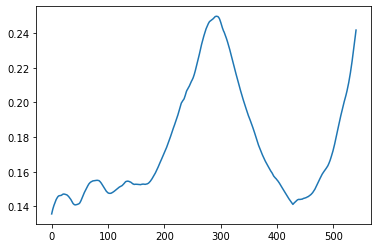

In [14]:
u,s,vt=np.linalg.svd(E)
t=-u[...,-1].reshape(3,1)*0.3
W=np.array([0,-1,0,1,0,0,0,0,1],dtype='float32').reshape(3,3)
R=np.dot(np.dot(u,W),vt)
P1=np.dot(leftUndist.P[0:3,0:3],np.hstack([np.eye(3),np.zeros((3,1))]))
P2=np.dot(rightUndist.P[0:3,0:3],np.hstack([R,t]))
points=cv2.triangulatePoints(P1,P2,extracted_points1.reshape(1,-1,2),extracted_points2.reshape(1,-1,2))
points_normalized=np.vstack([points[:,i]/points[-1,i] for i in range(len(points.T))])
# ax = plt.axes(projection='3d')
# ax.plot3D(points_normalized[:,0],points_normalized[:,1],points_normalized[:,2],'r.')
plt.plot(points_normalized[:,2])
plt.show()

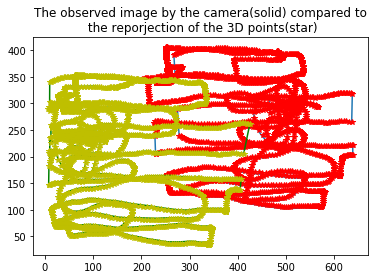

In [15]:
#Lets project the identified points on to the image plane to see if they match the expected model
reprojected1=np.dot(P1,points_normalized.T)
reprojected1=np.vstack([reprojected1[:,i]/reprojected1[-1,i] for i in range(len(reprojected1.T))])

reprojected2=np.dot(P2,points_normalized.T)
reprojected2=np.vstack([reprojected2[:,i]/reprojected2[-1,i] for i in range(len(reprojected2.T))])
plt.plot(extracted_points1[:,0],extracted_points1[:,1])
plt.plot(reprojected1[:,0],reprojected1[:,1],'r*')
plt.plot(extracted_points2[:,0],extracted_points2[:,1],'g')
plt.plot(reprojected2[:,0],reprojected2[:,1],'y*')
plt.title('The observed image by the camera(solid) compared to\n the reporjection of the 3D points(star)')
plt.show()

Calculating the Essential matrix using the camera matrices and the Fundamental matrix

In [16]:
import scipy.io
scipy.io.savemat('ess_fund_mats.mat',{'E':E,'F':F})
scipy.io.savemat('left_camera_params.mat',{'K':leftUndist.K,'D':leftUndist.D,'P':leftUndist.P})
scipy.io.savemat('right_camera_params.mat',{'K':rightUndist.K,'D':rightUndist.D,'P':rightUndist.P})

## Calibration with pixels directly extracted from the point based rectifier

In [17]:
#Testing the algorithm with a stream of images
markerExteractor_inst=markerExteractor()
cap1=cv2.VideoCapture('output_left2.avi')
cap2=cv2.VideoCapture('output_right2.avi')

extracted_points1_new=[]
extracted_points2_new=[]

frame_counter=0;
while cap1.isOpened():
    ret,img1=cap1.read()
    ret,img2=cap2.read()
    if(img1 is not None) and (img2 is not None):
        points1=markerExteractor_inst.detect(img1)
        points2=markerExteractor_inst.detect(img2)
        if (points1 is not None) and (points2 is not None):
            if (len(points1)==1) and (len(points2)==1):#Add points to the list only if is just one point in each image
                cv2.circle(img1,(int(round(points1[0,0])), int(round(points1[0,1]))), 2, (255,0,255), -1)
                cv2.circle(img2,(int(round(points2[0,0])), int(round(points2[0,1]))), 2, (255,0,255), -1)
                extracted_points1_new.append(leftUndist.process(points1[0])[0:2].reshape(1,2))
                extracted_points2_new.append(rightUndist.process(points2[0])[0:2].reshape(1,2))
                img_full=np.hstack([img1,img2])
                cv2.imshow('Frame',img_full)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                if frame_counter>6000:
                    break
                frame_counter=frame_counter+1
    else:
            cv2.destroyAllWindows()     
            cap1.release()
            cap2.release()
cv2.destroyAllWindows()     
cap1.release()
cap2.release()

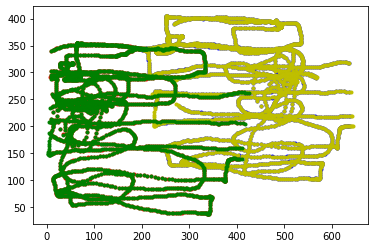

In [18]:
extracted_points1_new=np.vstack(extracted_points1_new)
extracted_points2_new=np.vstack(extracted_points2_new)
plt.plot(extracted_points1[:,0],extracted_points1[:,1],'b.')
plt.plot(extracted_points2[:,0],extracted_points2[:,1],'r.')

plt.plot(extracted_points1_new[:,0],extracted_points1_new[:,1],'y.')
plt.plot(extracted_points2_new[:,0],extracted_points2_new[:,1],'g.')
plt.show()

In [19]:
F,masks =cv2.findFundamentalMat(extracted_points1_new,extracted_points2_new)
E=np.dot(np.dot((rightUndist.P[0:3,0:3]).T,F),(leftUndist.P[0:3,0:3]))
np.linalg.svd(E)

(array([[-0.0197198 , -0.02225779,  0.99955776],
        [-0.87297426,  0.48772478, -0.00636202],
        [-0.48736748, -0.87271366, -0.02904832]]),
 array([1.09897448e+01, 1.07219140e+01, 2.85276298e-11]),
 array([[ 0.0105688 ,  0.45700205, -0.88940285],
        [-0.00721216,  0.88946423,  0.45694789],
        [-0.99991814, -0.00158512, -0.01269654]]))

[[0.00504489]]


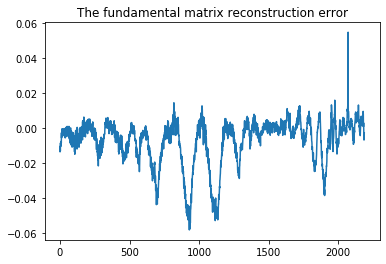

In [20]:
idx=200
P1=np.hstack([extracted_points1_new[idx,:] ,1])
P2=np.hstack([extracted_points2_new[idx,:] ,1])
P1=P1.reshape(3,1)
P2=P2.reshape(3,1)
print(np.dot(np.dot(P2.T,F),P1))
error=[]
for i in range(len(extracted_points1_new)):
    P1=np.hstack([extracted_points1_new[i,:] ,1])
    P2=np.hstack([extracted_points2_new[i,:] ,1])
    P1=P1.reshape(3,1)
    P2=P2.reshape(3,1)
    error.append(np.dot(np.dot(P2.T,F),P1))
error=np.array(error).reshape(-1)
plt.plot(error)
plt.title('The fundamental matrix reconstruction error')
plt.show()

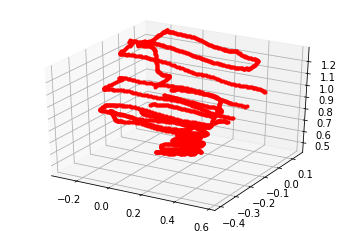

In [21]:
u,s,vt=np.linalg.svd(E)
t=u[...,-1].reshape(3,1)*0.3
W=np.array([0,-1,0,1,0,0,0,0,1],dtype='float32').reshape(3,3)
R=np.dot(np.dot(u,W.T),vt)
P1=np.dot(leftUndist.P[0:3,0:3],np.hstack([np.eye(3),np.zeros((3,1))]))
P2=np.dot(rightUndist.P[0:3,0:3],np.hstack([R,t]))
points=cv2.triangulatePoints(P1,P2,extracted_points1_new.reshape(-1,1,2),extracted_points2_new.reshape(-1,1,2))
points_normalized=np.vstack([points[:,i]/points[-1,i] for i in range(len(points.T))])
ax = plt.axes(projection='3d')
ax.plot3D(points_normalized[:,0],points_normalized[:,1],points_normalized[:,2],'r.')
#plt.plot(points_normalized[:,1])
plt.show()

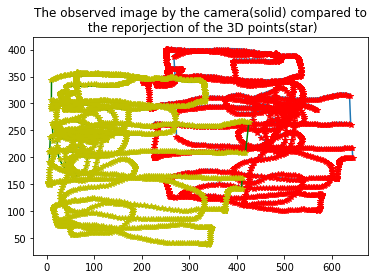

In [22]:
#Lets project the identified points on to the image plane to see if they match the expected model
reprojected1=np.dot(P1,points_normalized.T)
reprojected1=np.vstack([reprojected1[:,i]/reprojected1[-1,i] for i in range(len(reprojected1.T))])

reprojected2=np.dot(P2,points_normalized.T)
reprojected2=np.vstack([reprojected2[:,i]/reprojected2[-1,i] for i in range(len(reprojected2.T))])
plt.plot(extracted_points1_new[:,0],extracted_points1_new[:,1])
plt.plot(reprojected1[:,0],reprojected1[:,1],'r*')
plt.plot(extracted_points2_new[:,0],extracted_points2_new[:,1],'g')
plt.plot(reprojected2[:,0],reprojected2[:,1],'y*')
plt.title('The observed image by the camera(solid) compared to\n the reporjection of the 3D points(star)')
plt.show()

## Now let's see what happens if we directly identify the essential matrix from the normalized coordinates

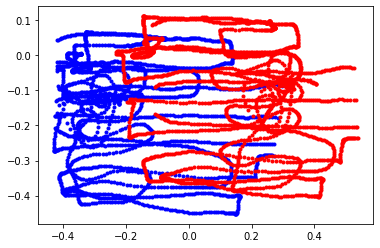

In [45]:
#Testing the algorithm with a stream of images
markerExteractor_inst=markerExteractor()
cap1=cv2.VideoCapture('output_left2.avi')
cap2=cv2.VideoCapture('output_right2.avi')

extracted_points1_normalized=[]
extracted_points2_normalized=[]
extracted_points1_raw=[]
extracted_points2_raw=[]
frame_counter=0;
while cap1.isOpened():
    ret,img1=cap1.read()
    ret,img2=cap2.read()
    if(img1 is not None) and (img2 is not None):
        points1=markerExteractor_inst.detect(img1)
        points2=markerExteractor_inst.detect(img2)
        if (points1 is not None) and (points2 is not None):
            if (len(points1)==1) and (len(points2)==1):#Add points to the list only if is just one point in each image
                cv2.circle(img1,(int(round(points1[0,0])), int(round(points1[0,1]))), 2, (255,0,255), -1)
                cv2.circle(img2,(int(round(points2[0,0])), int(round(points2[0,1]))), 2, (255,0,255), -1)
                extracted_points1_normalized.append(leftUndist.process_normalized(points1[0])[0:2].reshape(1,2))
                extracted_points2_normalized.append(rightUndist.process_normalized(points2[0])[0:2].reshape(1,2))
                extracted_points1_raw.append(points1[0])
                extracted_points2_raw.append(points2[0])

                img_full=np.hstack([img1,img2])
                cv2.imshow('Frame',img_full)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                if frame_counter>6000:
                    break
                frame_counter=frame_counter+1
    else:
            cv2.destroyAllWindows()     
            cap1.release()
            cap2.release()
cv2.destroyAllWindows()     
cap1.release()
cap2.release()
extracted_points1_normalized=np.vstack(extracted_points1_normalized)
extracted_points2_normalized=np.vstack(extracted_points2_normalized)
plt.plot(extracted_points2_normalized[:,0],extracted_points2_normalized[:,1],'b.')
plt.plot(extracted_points1_normalized[:,0],extracted_points1_normalized[:,1],'r.')
plt.show()

In [46]:
# Class for estimating the essential matrix using the observed set of points in the two images.
#The data object is a list costructed as data=[img2_points,img1_points]
import numpy as np
class EssentialMatrixEstimator():
    def __init__(self):
        self.estimation_mode=1
        self.inlier_threshold=0.07
    def create_row(self,point2,point1):
        u1=point1[0]
        v1=point1[1]
        u2=point2[0]
        v2=point2[1]
        line=np.array(\
        [u1*u2, u1*v2, u1, v1*u2, v1*v2, v1, u2, v2, 1]\
        ).reshape(1,9)
        return line
    def fit(self,data):
        rows=[]
        for i in range(len(data[0])):
            rows.append(self.create_row(data[0][i,:],data[1][i,:]))
        A=np.vstack(rows)
        u,s,v=np.linalg.svd(A)
        self.E=v.T[:,8].reshape(3,3).T
        u,s,v=np.linalg.svd(self.E)
        s[2]=0
        self.E=np.matmul(u * s, v)
        return self.E
    def get_performace(self,data):
        error=[]
        for i in range(len(data[0])):
            P1=np.hstack([data[0][i,:] ,1])
            P2=np.hstack([data[1][i,:] ,1])
            P1=P1.reshape(3,1)
            P2=P2.reshape(3,1)
            error.append(np.dot(np.dot(P2.T,self.E),P1))
        error=np.array(error).reshape(-1)
        cost=np.sum(error**2)
        return 1.0/cost
    def get_score(self,data,E):
        error=[]
        inliers=0
        for i in range(len(data[0])):
            P1=np.hstack([data[0][i,:] ,1])
            P2=np.hstack([data[1][i,:] ,1])
            P1=P1.reshape(3,1)
            P2=P2.reshape(3,1)
            dis=np.dot(np.dot(P2.T,E),P1)
            if np.abs(dis)<self.inlier_threshold:
                inliers=inliers+1
        return inliers
    def get_mask(self,data,E):
        mask=np.zeros((data[0].shape[0],1))
        for i in range(len(data[0])):
            P1=np.hstack([data[0][i,:] ,1])
            P2=np.hstack([data[1][i,:] ,1])
            P1=P1.reshape(3,1)
            P2=P2.reshape(3,1)
            dis=np.dot(np.dot(P2.T,E),P1)
            if np.abs(dis)<self.inlier_threshold:
                mask[i]=1
        return mask
    def fit_ransac(self,data, max_iters=100, samples_to_fit=8,inlierThreshold=None):    
        best_model = None
        max_number_of_inliers = 0
        if inlierThreshold is not None:
            self.inlier_threshold=inlierThreshold

        num_samples = data[0].shape[0]
        progress=[]
        for i in range(max_iters):
            samples = np.random.choice(num_samples, size=samples_to_fit, replace=False)
            model_params = self.fit([data[0][samples,:],data[1][samples,:]])
            number_of_inliers = self.get_score(data,model_params) #How many inliers for
                                                                                   #the given model?
            if number_of_inliers > max_number_of_inliers:
                best_model = model_params
                max_number_of_inliers = number_of_inliers
                progress.append(number_of_inliers)
        return progress,best_model

In [47]:
#Create the data object and estimate the E matrix with clean data
ess=EssentialMatrixEstimator()
data=[extracted_points2_normalized.copy(),extracted_points1_normalized.copy()]
E = ess.fit(data)

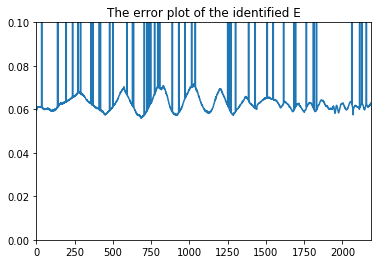

Given the perfect E and contaminated data we have 2083 inliers


In [9]:
#Now contaminate the data with some nasty outliers
contaminated_locations = np.random.choice(data[0].shape[0], size=50, replace=False) #size=number of outliers
data[0][contaminated_locations,:]=np.array([np.random.randint(1,15,2)]).reshape(1,2)
data[1][contaminated_locations,:]=np.array([np.random.randint(1,15,2)]).reshape(1,2)
#create an error plot of the data
error=[]
for i in range(len(extracted_points1_normalized)):
    P1=np.hstack([data[0][i,:] ,1])
    P2=np.hstack([data[1][i,:] ,1])
    P1=P1.reshape(3,1)
    P2=P2.reshape(3,1)
    error.append(np.abs(np.dot(np.dot(P2.T,E),P1)))
error=np.array(error).reshape(-1)
plt.plot(error)
plt.axis([0,data[0].shape[0],0,0.1])
plt.title('The error plot of the identified E')
plt.show()
# ess.fit(data)
# plt.plot(ess.get_mask(data,-1,E))
print(f'Given the perfect E and contaminated data we have {ess.get_score(data,E)} inliers')

In [10]:
progress,E=ess.fit_ransac(data,max_iters=100,samples_to_fit=20,inlierThreshold=0.07)
progress

[2138]

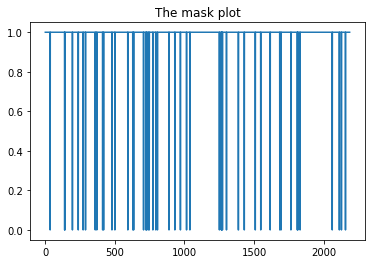

In [11]:
plt.plot(ess.get_mask(data,E))
plt.title('The mask plot')
plt.show()

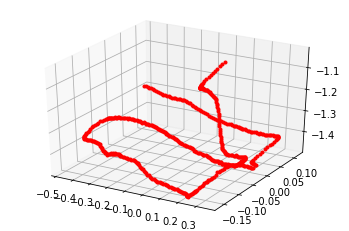

In [163]:
u,s,vt=np.linalg.svd(E)
t=-u[...,-1].reshape(3,1)*0.3
W=np.array([0,-1,0,1,0,0,0,0,1],dtype='float32').reshape(3,3)
R=np.dot(np.dot(u,W.T),vt)
P1=np.dot(leftUndist.P[0:3,0:3],np.hstack([np.eye(3),np.zeros((3,1))]))
P2=np.dot(rightUndist.P[0:3,0:3],np.hstack([R,t]))
points=cv2.triangulatePoints(P1,P2,extracted_points1.reshape(-1,1,2),extracted_points2.reshape(-1,1,2))
points_normalized=np.vstack([points[:,i]/points[-1,i] for i in range(len(points.T))])
ax = plt.axes(projection='3d')
ax.plot3D(points_normalized[:,0],points_normalized[:,1],points_normalized[:,2],'r.')
# plt.plot(points_normalized[:,1])
plt.show()

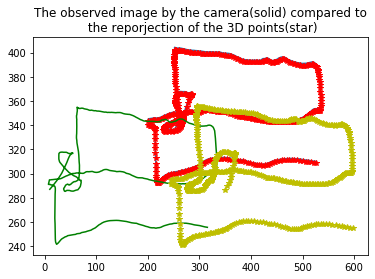

In [162]:
#Lets project the identified points on to the image plane to see if they match the expected model
reprojected1=np.dot(P1,points_normalized.T)
reprojected1=np.vstack([reprojected1[:,i]/reprojected1[-1,i] for i in range(len(reprojected1.T))])

reprojected2=np.dot(P2,points_normalized.T)
reprojected2=np.vstack([reprojected2[:,i]/reprojected2[-1,i] for i in range(len(reprojected2.T))])
plt.plot(extracted_points1[:,0],extracted_points1[:,1])
plt.plot(reprojected1[:,0],reprojected1[:,1],'r*')
plt.plot(extracted_points2[:,0],extracted_points2[:,1],'g')
plt.plot(reprojected2[:,0],reprojected2[:,1],'y*')
plt.title('The observed image by the camera(solid) compared to\n the reporjection of the 3D points(star)')
plt.show()

## Now let's do the triangulation using the miniSAM library

In [15]:
from minisam import *
factor=FactorGraph()
# factor graph container
graph = FactorGraph()

# Add a prior on the first pose, setting it to the origin
priorLoss = DiagonalLoss.Sigmas(np.array([1.0, 1.0, 0.1])) # prior loss function
graph.add(PriorFactor(key('x', 1), SE2(SO2(0), np.array([0, 0])), priorLoss))

# Add odometry factors
odomLoss = DiagonalLoss.Sigmas(np.array([0.5, 0.5, 0.1])) # odometry measurement loss function
graph.add(BetweenFactor(key('x', 1), key('x', 2), SE2(SO2(0), np.array([5, 0])), odomLoss))
graph.add(BetweenFactor(key('x', 2), key('x', 3), SE2(SO2(-1.57), np.array([5, 0])), odomLoss))
graph.add(BetweenFactor(key('x', 3), key('x', 4), SE2(SO2(-1.57), np.array([5, 0])), odomLoss))
graph.add(BetweenFactor(key('x', 4), key('x', 5), SE2(SO2(-1.57), np.array([5, 0])), odomLoss))

# Add the loop closure constraint
loopLoss = DiagonalLoss.Sigmas(np.array([0.5, 0.5, 0.1])) # loop closure measurement loss function
graph.add(BetweenFactor(key('x', 5), key('x', 2), SE2(SO2(-1.57), np.array([5, 0])), loopLoss))

In [16]:
# initial varible values for the optimization
# add random noise from ground truth values
initials = Variables()
initials.add(key('x', 1), SE2(SO2(0.2), np.array([0.2, -0.3])))
initials.add(key('x', 2), SE2(SO2(-0.1), np.array([5.1, 0.3])))
initials.add(key('x', 3), SE2(SO2(-1.57 - 0.2), np.array([9.9, -0.1])))
initials.add(key('x', 4), SE2(SO2(-3.14 + 0.1), np.array([10.2, -5.0])))
initials.add(key('x', 5), SE2(SO2(1.57 - 0.1), np.array([5.1, -5.1])))

In [17]:
# Use LM method optimizes the initial values
opt_param = LevenbergMarquardtOptimizerParams()
opt = LevenbergMarquardtOptimizer(opt_param)

# result variables container
results = Variables()
status = opt.optimize(graph, initials, results)

if status != NonlinearOptimizationStatus.SUCCESS:
    print("optimization error: ", status)

In [18]:
# Calculate marginal covariances for poses
mcov_solver = MarginalCovarianceSolver()

status = mcov_solver.initialize(graph, results)
if status != MarginalCovarianceSolverStatus.SUCCESS:
    print("maginal covariance error", status)

cov1 = mcov_solver.marginalCovariance(key('x', 1))

In [19]:
# GPS translation measurement factor
class GPSPositionFactor(Factor):
    # ctor
    def __init__(self, key, point, loss):
        Factor.__init__(self, 1, [key], loss)
        self.p_ = point

    # make a deep copy
    def copy(self):
        return GPSPositionFactor(self.keys()[0], self.p_, self.lossFunction())

    # error
    def error(self, variables):
        pose = variables.at(self.keys()[0])
        return pose.translation() - self.p_

    # jacobians
    def jacobians(self, variables):
        return [np.array([[1, 0, 0], [0, 1, 0]])]

    # optional print function
    def __repr__(self):
        return 'GPS Factor on SE(2):\nprior = ' + self.p_.__repr__() + ' on ' + keyString(self.keys()[0]) + '\n'

In [20]:
# factor graph container
graph = FactorGraph()

# Add odometry factors
odomLoss = ScaleLoss.Scale(1.0) # odometry measurement loss function
graph.add(BetweenFactor(key('x', 1), key('x', 2), SE2(SO2(0), np.array([5, 0])), odomLoss))
graph.add(BetweenFactor(key('x', 2), key('x', 3), SE2(SO2(0),np.array([5, 0])), odomLoss))

# Add the GPS factors
gpsLoss = DiagonalLoss.Sigmas(np.array([2.0, 2.0])); # 2D 'GPS' measurement loss function, 2-dim
graph.add(GPSPositionFactor(key('x', 1), np.array([0, 0]), gpsLoss))
graph.add(GPSPositionFactor(key('x', 2), np.array([5, 0]), gpsLoss))
graph.add(GPSPositionFactor(key('x', 3), np.array([10, 0]), gpsLoss))

Defining a custom type (Manifold)

In [21]:
# 2D point optimizable in miniSAM
class Point2D(object):
    # constructor
    def __init__(self, x, y):
        self.x_ = float(x)
        self.y_ = float(y)

    # print function
    def __repr__(self):
        return 'custom 2D point [' + str(self.x_) + ', ' + str(self.y_) + ']\''

    # local coordinate dimension
    def dim(self):
        return 2

    # map manifold point other to local coordinate
    def local(self, other):
        return np.array([other.x_ - self.x_, other.y_ - self.y_], dtype=np.float)

    # apply changes in local coordinate to manifold, \oplus operator
    def retract(self, vec):
        return Point2D(self.x_ + vec[0], self.y_ + vec[1])

In [377]:
# Numerical
class triangulationFactor(NumericalFactor):
    # ctor
    def __init__(self, key, point, loss,R,T,K):
        NumericalFactor.__init__(self, 1, [key], loss)
        self.p_ = point
        self.R=R
        self.T=T
        self.K=K
        self.fx=K[0,0]
        self.fy=K[1,1]
        self.cx=K[0,2]
        self.cy=K[1,2]

    # make a deep copy
    def copy(self):
        return triangulationFactor(self.keys()[0], self.p_, self.lossFunction(),self.R,self.T,self.K)

    # error
    def error(self, variables):
        pose = variables.at(self.keys()[0])
        Xc=self.R@pose.translation().reshape(3,1)+self.T
        hx=Xc[0]*self.fx/Xc[2]+self.cx
        hy=Xc[1]*self.fy/Xc[2]+self.cy
        return np.array([hx-self.p_[0],hy-self.p_[1]]).reshape(2,1)

    # optional print function
#    def __repr__(self):
#        return 'Triangulation Factor :\nprior = ' + self.p_.__repr__() + ' on ' + keyString(self.keys()[0]) + '\n'

In [393]:
# Closed Form
class triangulationFactor(Factor):
    # ctor
    def __init__(self, key, point, loss,R,T,K):
        Factor.__init__(self, 1, [key], loss)
        self.p_ = point
        self.R=R
        self.T=T
        self.K=K
        self.fx=K[0,0]
        self.fy=K[1,1]
        self.cx=K[0,2]
        self.cy=K[1,2]

    # make a deep copy
    def copy(self):
        return triangulationFactor(self.keys()[0], self.p_, self.lossFunction(),self.R,self.T,self.K)

    # error
    def error(self, variables):
        pose = variables.at(self.keys()[0])
        Xc=self.R@pose.translation().reshape(3,1)+self.T
        hx=Xc[0]*self.fx/Xc[2]+self.cx
        hy=Xc[1]*self.fy/Xc[2]+self.cy
        return np.array([hx-self.p_[0],hy-self.p_[1]]).reshape(2,1)

    # jacobians
    def jacobians(self, variables):
        pose = variables.at(self.keys()[0])
        Xc=np.squeeze((self.R@pose.translation().reshape(3,1)+self.T))
        H_prime=np.array([[self.fx/Xc[2], 0, -(self.fx*Xc[0]/(Xc[2]**2))],[0, self.fy/Xc[2],-(self.fy*Xc[1]/(Xc[2]**2))]])
        j=H_prime@(self.R)
        return [np.hstack([j,np.zeros((2,3))])]#

    # optional print function
#    def __repr__(self):
#        return 'Triangulation Factor :\nprior = ' + self.p_.__repr__() + ' on ' + keyString(self.keys()[0]) + '\n'

In [402]:
#Create Test data
idx=1000
#Extract the R and T from the Essential matrix
u,s,vt=np.linalg.svd(E)
t=u[...,-1].reshape(3,1)*0.3
W=np.array([0,-1,0,1,0,0,0,0,1],dtype='float32').reshape(3,3)
R=np.dot(np.dot(u,W.T),vt)
P1=np.dot(leftUndist.K[0:3,0:3],np.hstack([np.eye(3),np.zeros((3,1))]))
P2=np.dot(rightUndist.K[0:3,0:3],np.hstack([R,t]))
#save the undistorded opserved points by the camera in the normalized co0rdinate
pl=cv2.convertPointsToHomogeneous(np.squeeze(extracted_points1_normalized[idx,:]).reshape(-1,1,2)).reshape(3,1)
pr=cv2.convertPointsToHomogeneous(np.squeeze(extracted_points2_normalized[idx,:]).reshape(-1,1,2)).reshape(3,1)
#map the marker postions back onto the pixel coordinate
pl=(leftUndist.K@pl)[0:2].reshape(-1,1,2)
pr=(rightUndist.K@pr)[0:2].reshape(-1,1,2)
#using the opencv's triangulation function find the 3D location of the marker 
p_test=cv2.triangulatePoints(P1,P2,pl,pr)
p=(p_test/p_test[3])[0:3].reshape(3,1)
print(p)
#What is the reprojection error? 
fx=rightUndist.K[0,0]
fy=rightUndist.K[1,1]
cx=rightUndist.K[0,2]
cy=rightUndist.K[1,2]
Xc=R@p+t
hx=Xc[0]*fx/Xc[2]+cx
hy=Xc[1]*fy/Xc[2]+cy
[hx-pr[0,0,0],hy-pr[0,0,1]]



[[ 0.41668236]
 [-0.38256793]
 [ 1.08548756]]


[array([-0.00027297]), array([-0.02135569])]

In [401]:

# factor graph container
graph = FactorGraph()
priorLoss = DiagonalLoss.Sigmas(np.array([1e10, 1e10,1e10,1e-3,1e-3,1e-3])) # prior loss function
graph.add(PriorFactor(key('x', 1), SE3(SO3(np.eye(3)), np.array([0, 0,0])), priorLoss))
# Add the  triangulation factors
cameraLoss = DiagonalLoss.Sigmas(np.array([0.1, 0.1])); # 2D 'GPS' measurement loss function, 2-dim
graph.add(triangulationFactor(key('x', 1), np.array([pl[0,0,0],pl[0,0,1]]), cameraLoss,np.eye(3),np.zeros((3,1)),leftUndist.K))
graph.add(triangulationFactor(key('x', 1), np.array([pr[0,0,0],pr[0,0,1]]), cameraLoss,R,t,rightUndist.K))
initials = Variables()
initials.add(key('x', 1), SE3(SO3(np.eye(3)), np.array([1, 1,1])))
# Use LM method optimizes the initial values
opt_param = LevenbergMarquardtOptimizerParams()
opt = LevenbergMarquardtOptimizer(opt_param)

# result variables container
results = Variables()
status = opt.optimize(graph, initials, results)

if status != NonlinearOptimizationStatus.SUCCESS:
    print("optimization error: ", status)
results

Key = x1, value = Sophus::SE3d
t = [0.416682, -0.382567, 1.08549]'
R = 
1 0 0
0 1 0
0 0 1

In [379]:
#For testing the numerical solution
test=triangulationFactor(key('x', 1), np.array([pr[0,0,0],pr[0,0,1]]), cameraLoss,R,t,rightUndist.K)
test.error(initials)
test.jacobians(initials)[0]

array([[ 647.12198602,  -11.67767636, -440.79173823,    0.        ,
           0.        ,    0.        ],
       [   2.63302645,  615.82905295, -616.30243941,    0.        ,
           0.        ,    0.        ]])

In [396]:
#For testing the closed form solution
test=triangulationFactor(key('x', 1), np.array([pr[0,0,0],pr[0,0,1]]), cameraLoss,R,t,rightUndist.K)
test.error(initials)
test.jacobians(initials)[0]

array([[ 647.12198602,  -11.67767636, -440.79173823,    0.        ,
           0.        ,    0.        ],
       [   2.63302645,  615.82905295, -616.30243941,    0.        ,
           0.        ,    0.        ]])

In [412]:
# The factor graph for triangulating a merker seen by multiple cameras
def multiCameraTriangulation(Rs,Ts,Ps,Ks):
    graph = FactorGraph()
    initials = Variables()
    results = Variables()
    priorLoss = DiagonalLoss.Sigmas(np.array([1e10, 1e10,1e10,1e-3,1e-3,1e-3])) # prior loss function
    graph.add(PriorFactor(key('x', 1), SE3(SO3(np.eye(3)), np.array([0,0,0])), priorLoss))
    # Add the  triangulation factors
    cameraLoss = DiagonalLoss.Sigmas(np.array([0.1, 0.1])); # 2D 'GPS' measurement loss function, 2-dim
    for i,P in enumerate(Ps):
        graph.add(triangulationFactor(key('x', 1), np.array([np.squeeze(P)[0],np.squeeze(P)[1]]), cameraLoss,Rs[i],Ts[i],Ks[i]))
    initials.add(key('x', 1), SE3(SO3(np.eye(3)), np.array([1, 1,1])))
    # Use LM method optimizes the initial values
    opt_param = LevenbergMarquardtOptimizerParams()
    opt = LevenbergMarquardtOptimizer(opt_param)
    # result variables container
    status = opt.optimize(graph, initials, results)
    if status != NonlinearOptimizationStatus.SUCCESS:
        print("optimization error: ", status)
    return status,results

In [413]:
Ps=[pl,pr]
Rs=[np.eye(3),R]
Ts=[np.zeros((3,1)),t]
Ks=[leftUndist.K,rightUndist.K]
multiCameraTriangulation(Rs,Ts,Ps,Ks)

(NonlinearOptimizationStatus.SUCCESS, Key = x1, value = Sophus::SE3d
 t = [0.416682, -0.382567, 1.08549]'
 R = 
 1 0 0
 0 1 0
 0 0 1)

In [ ]:
#!/usr/bin/env python
import rospy
import cv2
from cv_bridge import CvBridge
from ir_marker_extractor.msg import ir_markers
from geometry_msgs.msg import Point
from sensor_msgs.msg import Image
from pyclustering.cluster.bsas import bsas
from dynamic_reconfigure.server import Server
from ir_marker_extractor.cfg import ir_marker_extractor_cfgsConfig
import numpy as np

def recongigureator_callback(config,level):
	marker_extractor.max_clusters=config.max_clusters
	marker_extractor.maxWhitePixels=config.max_white_pixels
	marker_extractor.threshold=config.global_threshold
	marker_extractor.minThreshold=config.blub_min_threshold
	marker_extractor.maxThreshold=config.blub_max_threshold
	marker_extractor.filterByArea=config.blub_filterByArea
	marker_extractor.minArea=config.blub_minArea
	marker_extractor.filterByCircularity=config.blub_filterByCircularity
	marker_extractor.minCircularity=config.blub_minCircularity
	marker_extractor.filterByConvexity=config.blub_filterByConvexity
	marker_extractor.minConvexity=config.blub_minConvexity
	marker_extractor.filterByInertia=config.blub_filterByInertia
	marker_extractor.minInertiaRatio=config.blub_minInertiaRatio
	marker_extractor.blobColor=config.blub_color
	marker_extractor.updateParameters()
	return config

class markerExteractor(object):
    def __init__(self):
        self.maxWhitePixels=300
        self.max_clusters = 8
        self.threshold = 20
        self.blubParams = cv2.SimpleBlobDetector_Params()
        self.blubParams.minThreshold = 50;
        self.blubParams.maxThreshold = 255;
        self.blubParams.filterByArea = True
        self.blubParams.minArea = 0
        self.blubParams.filterByCircularity = True
        self.blubParams.minCircularity = 0.3
        self.blubParams.filterByConvexity = True
        self.blubParams.minConvexity = 0.7
        self.blubParams.filterByInertia = True
        self.blubParams.minInertiaRatio = 0.1
        self.blubParams.blobColor = 255
        ver = (cv2.__version__).split('.')
        if int(ver[0]) < 3 :
            self.blubDetector = cv2.SimpleBlobDetector(self.blubParams)
        else :
            self.blubDetector = cv2.SimpleBlobDetector_create(self.blubParams)
    def updateParameters(self):
		self.blubDetector = cv2.SimpleBlobDetector(self.blubParams)
    def detect(self,frame):
        self.cms=[]
        self.image_ROIs=[]
        self.keypoints=[]
        if len(frame.shape)==2:
            img_gray=frame
        else:
            img_gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret,img_thresh = cv2.threshold(img_gray,100,255,cv2.THRESH_TOZERO)
        #Find the clusters
        self.nonzro_samples = cv2.findNonZero(img_thresh)
        if self.nonzro_samples is None:
            return -1,None  #No markers in the image
        else:
            self.nonzro_samples=self.nonzro_samples.reshape(-1, 2).astype('float32')
        if self.nonzro_samples.shape[0]<self.maxWhitePixels:
            bsas_instance = bsas(self.nonzro_samples, self.max_clusters, self.threshold)
            bsas_instance.process()
            clusters = bsas_instance.get_clusters()
            #Calculate the center of the clusters and the Regions of Interests
            self.ROIs=np.zeros((len(clusters),4))
            for i,cluster in enumerate(clusters):
                current_batch=self.nonzro_samples[cluster]
                self.cms.append(np.sum(current_batch,axis=0)/current_batch.shape[0])
                row_max=np.max(current_batch[:,1],axis=0)+6
                row_min=np.min(current_batch[:,1],axis=0)-6
                col_max=np.max(current_batch[:,0],axis=0)+6
                col_min=np.min(current_batch[:,0],axis=0)-6
                self.ROIs[i,:]=[row_min,row_max,col_min,col_max]
            for roi in self.ROIs.astype('int32'):
                self.image_ROIs.append(img_thresh.copy()[roi[0]:roi[1],roi[2]:roi[3]])
            #Return The Results
            marker_points=[]
            for i,roi in enumerate(self.image_ROIs):
                keys_in_roi=self.blubDetector.detect(roi)
                for key in keys_in_roi:
                    #Calculate the global coordinate of marker points.
					#The points are returned in (X(Col),Y(Row)) coordinate.
                    marker_points.append([key.pt[0]+self.ROIs.astype('float32')\
					[i,2],key.pt[1]+self.ROIs.astype('float32')[i,0]])
            return 0,np.array(marker_points)
        else:
            return -2,None

def image_callback(image):
    cv_image=bridge.imgmsg_to_cv2(image,desired_encoding='mono8')
    #print(cv_image.shape)
    status,markers=marker_extractor.detect(cv_image)
    if True:
        img_color=cv2.cvtColor(img_gray,cv2.COLOR_GRAY2BGR)
        for marker in markers:
            cv2.circle(img_color,(int(round(marker[0])), int(round(marker[1]))), 3, (255,0,255), -1)
        debug_image=bridge.cv2_to_imgmsg(image,desired_encoding='bgr8')
        debug_image_pub.publish(debug_image)
		
	if status==-2: #too many white pixels in the image
        #print('too many white pixels dtected in the image')
        markers_msg.status=status
        markers_msg.header.stamp=image.header.stamp
        pub.publish(markers_msg)
        return
    if status==-1 or len(markers)==0: #no markers in the image
        #print('no markers in the image')
        markers_msg.status=status
        markers_msg.header.stamp=image.header.stamp
        pub.publish(markers_msg)
        return

	marker_list=[]
    for marker in markers:
        marker_list.append(Point(marker[0],marker[1],0))
    markers_msg.status=status
    markers_msg.header.stamp=image.header.stamp
    markers_msg.markers=markers_msg.markers=marker_list
    #[Point(np.random.randn(),2,3),Point(4,5,6)]#
    pub.publish(markers_msg)

if __name__ =='__main__':
	bridge=CvBridge()
	marker_extractor=markerExteractor()
	markers_msg=ir_markers()
	rospy.init_node('ir_marker_extractor_node')
	if rospy.has_param('~debug_image'):
		debug_image=rospy.get_param('~debug_image')
		debug_image_pub=rospy.Publisher('/ir_marker_extractor/debug_image',Image,queue_size=1)
		debug_image=True
	else:
		debug_image=False
	pub=rospy.Publisher('/ir_marker_extractor/ir_markers',ir_markers,queue_size=1)
	rospy.Subscriber('/camera/image_raw',Image,image_callback)
	srv=Server(ir_marker_extractor_cfgsConfig,recongigureator_callback)
	rospy.spin()
